In [1]:
# Optional: install dependencies inside this environment.
# %pip install torch torchvision timm datasets pandas matplotlib tqdm seaborn scikit-learn
!git clone https://github.com/davda54/sam external/sam

Cloning into 'external/sam'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 200 (delta 85), reused 67 (delta 67), pack-reused 97 (from 1)
Receiving objects: 100% (200/200), 657.08 KiB | 11.95 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [2]:
import os
import subprocess
import sys
import contextlib
import copy
import random
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import torch
from datasets import load_dataset
from torch import nn
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import models, transforms
from tqdm.auto import tqdm

try:
    import timm
except Exception:
    timm = None

try:
    from torchvision.models import ResNet18_Weights, ResNet50_Weights, Swin_T_Weights
except Exception:
    ResNet18_Weights = ResNet50_Weights = Swin_T_Weights = None

SAM_REPO = Path("external/sam")
if not SAM_REPO.exists():
    SAM_REPO.parent.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Cloning SAM into {SAM_REPO} ...")
    subprocess.run(["git", "clone", "https://github.com/davda54/sam", str(SAM_REPO)], check=True)

if str(SAM_REPO) not in sys.path:
    sys.path.insert(0, str(SAM_REPO))

from sam import SAM

plt.style.use("seaborn-v0_8")
torch.backends.cudnn.benchmark = True


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
@dataclass
class TrainingConfig:
    hf_dataset: str = "flwrlabs/pacs"
    hf_split: str = "train"
    hf_cache_dir: Optional[Path] = None
    source_domains: Tuple[str, ...] = ("art_painting", "cartoon", "photo")
    target_domain: str = "sketch"
    image_size: int = 224
    batch_size: int = 32
    num_workers: int = 4
    val_ratio: float = 0.1
    epochs: int = 10
    learning_rate: float = 3e-4
    weight_decay: float = 1e-4
    max_grad_norm: Optional[float] = None
    sam_rho: float = 0.03
    sam_base_optimizer: str = "auto"
    sam_momentum: float = 0.9
    sam_adaptive: bool = False
    resnet_lr: float = 1e-3
    resnet_weight_decay: float = 1e-4
    resnet_rho: float = 0.05
    swin_lr: float = 1e-4
    swin_weight_decay: float = 5e-2
    freeze_bn_on_second_step: bool = True
    architectures: Tuple[str, ...] = ("resnet18", "resnet50", "swin_t")
    pretrained: bool = True
    patience: int = 5
    min_delta: float = 1e-3
    output_dir: Path = Path("outputs/sam_baseline")
    seed: int = 42
    progress_bar: bool = True
    pin_memory: bool = True

    @property
    def num_classes(self) -> int:
        return 7

    def __post_init__(self) -> None:
        if self.hf_cache_dir is not None:
            self.hf_cache_dir = Path(self.hf_cache_dir)
        self.output_dir = Path(self.output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)


config = TrainingConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:
def set_seed(seed: int) -> None:
    """Set all relevant RNG seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(config.seed)


In [5]:
def build_transforms(image_size: int) -> Dict[str, transforms.Compose]:
    """Return train/eval transform pipelines."""
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    train_tfms = transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            normalize,
        ]
    )

    eval_tfms = transforms.Compose(
        [
            transforms.Resize(int(image_size * 1.15)),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            normalize,
        ]
    )

    return {"train": train_tfms, "eval": eval_tfms}


class HFImageDataset(Dataset):
    """Wrap a Hugging Face dataset with torchvision-style transforms."""

    def __init__(self, hf_dataset, transform):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int):
        example = self.dataset[int(idx)]
        image = example["image"]
        if hasattr(image, "convert"):
            image = image.convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = int(example["label"])
        return image, label


In [6]:
def prepare_dataloaders(cfg: TrainingConfig) -> Dict[str, object]:
    """Create dataloaders for train/val, target evaluation, and per-domain audits."""
    hf_kwargs = {}
    if cfg.hf_cache_dir is not None:
        hf_kwargs["cache_dir"] = str(cfg.hf_cache_dir)

    raw_dataset = load_dataset(cfg.hf_dataset, split=cfg.hf_split, **hf_kwargs)
    tfms = build_transforms(cfg.image_size)

    train_datasets: List[Dataset] = []
    val_datasets: List[Dataset] = []
    per_domain_eval: Dict[str, DataLoader] = {}
    domain_records: List[Dict[str, object]] = []

    for domain in cfg.source_domains:
        domain_ds = raw_dataset.filter(lambda example, domain_name=domain: example["domain"] == domain_name)
        domain_count = len(domain_ds)
        if domain_count == 0:
            raise ValueError(f"Domain '{domain}' is missing from {cfg.hf_dataset} ({cfg.hf_split} split).")

        if 0 < cfg.val_ratio < 1 and domain_count > 1:
            split = domain_ds.train_test_split(test_size=cfg.val_ratio, seed=cfg.seed, shuffle=True)
            train_split = split["train"]
            val_split = split["test"]
        else:
            train_split = domain_ds
            if domain_count > 0:
                val_size = max(1, domain_count // 10)
                val_split = domain_ds.shuffle(seed=cfg.seed).select(range(min(val_size, domain_count)))
            else:
                val_split = domain_ds

        train_datasets.append(HFImageDataset(train_split, tfms["train"]))
        val_datasets.append(HFImageDataset(val_split, tfms["eval"]))

        eval_dataset = HFImageDataset(domain_ds, tfms["eval"])
        per_domain_eval[domain] = DataLoader(
            eval_dataset,
            batch_size=cfg.batch_size,
            shuffle=False,
            num_workers=cfg.num_workers,
            pin_memory=cfg.pin_memory,
        )

        domain_records.append({"domain": domain, "split": "train", "count": len(train_split)})
        domain_records.append({"domain": domain, "split": "val", "count": len(val_split)})
        domain_records.append({"domain": domain, "split": "total", "count": domain_count})

    train_dataset = ConcatDataset(train_datasets)
    val_dataset = ConcatDataset(val_datasets)

    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
    )

    target_ds = raw_dataset.filter(lambda example: example["domain"] == cfg.target_domain)
    if len(target_ds) == 0:
        raise ValueError(f"Target domain '{cfg.target_domain}' is missing from {cfg.hf_dataset}.")

    target_loader = DataLoader(
        HFImageDataset(target_ds, tfms["eval"]),
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
    )

    domain_records.append({"domain": cfg.target_domain, "split": "target_total", "count": len(target_ds)})

    return {
        "train_loader": train_loader,
        "val_loader": val_loader,
        "target_loader": target_loader,
        "per_domain_loaders": per_domain_eval,
        "transforms": tfms,
        "domain_records": domain_records,
    }


In [7]:
def build_model(arch: str, num_classes: int, pretrained: bool = True) -> nn.Module:
    """Create a classifier head for the requested backbone."""
    arch = arch.lower()
    if arch in {"resnet18", "rn18"}:
        weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained and ResNet18_Weights else None
        model = models.resnet18(weights=weights)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        return model

    if arch in {"resnet50", "rn50"}:
        weights = ResNet50_Weights.IMAGENET1K_V2 if pretrained and ResNet50_Weights else None
        model = models.resnet50(weights=weights)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        return model

    if arch in {"swin_t", "swin_tiny"}:
        if hasattr(models, "swin_t"):
            weights = Swin_T_Weights.IMAGENET1K_V1 if pretrained and Swin_T_Weights else None
            model = models.swin_t(weights=weights)
            in_features = model.head.in_features
            model.head = nn.Linear(in_features, num_classes)
            return model
        if timm is None:
            raise RuntimeError(
                "Swin-Tiny backbone requires torchvision>=0.13 or the timm package. "
                "Install timm with `pip install timm`."
            )
        model = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=pretrained,
            num_classes=num_classes,
        )
        return model

    raise ValueError(f"Unsupported architecture: {arch}")


In [8]:
def run_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    *,
    optimizer: torch.optim.Optimizer = None,
    device: torch.device,
    scaler: torch.cuda.amp.GradScaler = None,
    grad_clip: float = None,
    desc: str = "epoch",
    progress: bool = True,
    amp_enabled: bool = False,
) -> Dict[str, float]:
    """Train or evaluate the model for one epoch."""
    if dataloader is None:
        return {"loss": float("nan"), "accuracy": float("nan")}

    is_train = optimizer is not None
    model.train(mode=is_train)

    iterator: Iterable = dataloader
    if progress:
        iterator = tqdm(dataloader, desc=desc, leave=False)

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in iterator:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        autocast_ctx = contextlib.nullcontext()
        if amp_enabled:
            autocast_ctx = torch.cuda.amp.autocast()

        with autocast_ctx:
            outputs = model(images)
            loss = criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            if scaler is not None and amp_enabled:
                scaler.scale(loss).backward()
                if grad_clip is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total if total else float("nan")
    accuracy = correct / total if total else float("nan")
    return {"loss": avg_loss, "accuracy": accuracy}


def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    *,
    device: torch.device,
    progress: bool = False,
    amp_enabled: bool = False,
) -> Dict[str, float]:
    """Wrapper around run_epoch for evaluation-only passes."""
    model.eval()
    with torch.no_grad():
        return run_epoch(
            model,
            dataloader,
            criterion,
            optimizer=None,
            device=device,
            scaler=None,
            grad_clip=None,
            desc="eval",
            progress=progress,
            amp_enabled=amp_enabled,
        )


In [9]:
def _set_bn_eval(model):
    for m in model.modules():
        if isinstance(m, nn.modules.batchnorm._BatchNorm):
            m.eval()

def _set_bn_train(model):
    for m in model.modules():
        if isinstance(m, nn.modules.batchnorm._BatchNorm):
            m.train()

def train_single_backbone(
    arch: str,
    cfg: TrainingConfig,
    loaders: Dict[str, object],
    *,
    device: torch.device,
) -> Tuple[pd.DataFrame, Dict[str, object]]:
    """Train a single backbone with Sharpness-Aware Minimization (SAM)."""
    model = build_model(arch, cfg.num_classes, pretrained=cfg.pretrained)
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Choose base optimizer per architecture
    base_opt = cfg.sam_base_optimizer.lower() if cfg.sam_base_optimizer else 'auto'
    arch_l = arch.lower()
    if base_opt == 'auto':
        if 'swin' in arch_l:
            base_optimizer = torch.optim.AdamW
            base_kwargs = dict(lr=cfg.swin_lr, weight_decay=cfg.swin_weight_decay)
        else:
            base_optimizer = torch.optim.SGD
            base_kwargs = dict(lr=cfg.resnet_lr, momentum=cfg.sam_momentum, weight_decay=cfg.resnet_weight_decay)
    elif base_opt == 'sgd':
        base_optimizer = torch.optim.SGD
        base_kwargs = dict(lr=cfg.learning_rate, momentum=cfg.sam_momentum, weight_decay=cfg.weight_decay)
    elif base_opt == 'adamw':
        base_optimizer = torch.optim.AdamW
        base_kwargs = dict(lr=cfg.learning_rate, weight_decay=cfg.weight_decay)
    else:
        raise ValueError(f"Unsupported sam_base_optimizer: {cfg.sam_base_optimizer}")

    rho = cfg.resnet_rho if 'resnet' in arch_l else cfg.sam_rho
    optimizer = SAM(model.parameters(), base_optimizer, rho=rho, adaptive=cfg.sam_adaptive, **base_kwargs)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer.base_optimizer, T_max=cfg.epochs)

    train_loader: DataLoader = loaders['train_loader']
    history: List[Dict[str, float]] = []
    best_state_dict = None
    best_val_acc = 0.0
    epochs_without_improve = 0

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_samples = 0

        iterator: Iterable = train_loader
        if cfg.progress_bar:
            iterator = tqdm(train_loader, desc=f"{arch} | train {epoch}/{cfg.epochs}", leave=False)

        for images, labels in iterator:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # First (ascent) step
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.first_step(zero_grad=True)

            # Optionally freeze BN stats during second (descent) step
            if cfg.freeze_bn_on_second_step:
                _set_bn_eval(model)

            criterion(model(images), labels).backward()
            optimizer.second_step(zero_grad=True)

            if cfg.freeze_bn_on_second_step:
                _set_bn_train(model)

            preds = outputs.argmax(dim=1)
            batch_size = labels.size(0)
            epoch_loss += loss.item() * batch_size
            epoch_correct += (preds == labels).sum().item()
            epoch_samples += batch_size

        scheduler.step()

        train_loss = epoch_loss / epoch_samples if epoch_samples else float('nan')
        train_accuracy = epoch_correct / epoch_samples if epoch_samples else float('nan')

        val_metrics = run_epoch(
            model,
            loaders['val_loader'],
            criterion,
            optimizer=None,
            device=device,
            scaler=None,
            grad_clip=None,
            desc=f"{arch} | val {epoch}/{cfg.epochs}",
            progress=cfg.progress_bar,
            amp_enabled=False,
        )

        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_metrics['loss'],
            'val_accuracy': val_metrics['accuracy'],
            'lr': optimizer.base_optimizer.param_groups[0]['lr'],
        })

        if val_metrics['accuracy'] > best_val_acc + cfg.min_delta:
            best_val_acc = val_metrics['accuracy']
            best_state_dict = copy.deepcopy(model.state_dict())
            epochs_without_improve = 0
        else:
            epochs_without_improve += 1

        if cfg.patience and epochs_without_improve >= cfg.patience:
            print(f"Stopping early at epoch {epoch} (no improvement for {cfg.patience} epochs).")
            break

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    history_df = pd.DataFrame(history)

    per_domain_metrics = {}
    for domain, domain_loader in loaders['per_domain_loaders'].items():
        metrics = evaluate_model(
            model,
            domain_loader,
            criterion,
            device=device,
            progress=False,
            amp_enabled=False,
        )
        per_domain_metrics[domain] = metrics

    target_metrics = evaluate_model(
        model,
        loaders['target_loader'],
        criterion,
        device=device,
        progress=False,
        amp_enabled=False,
    )

    avg_source_accuracy = float(np.mean([m['accuracy'] for m in per_domain_metrics.values()]))

    weights_path = cfg.output_dir / f"{arch}_sam_best.pt"
    torch.save(model.state_dict(), weights_path)

    history_path = cfg.output_dir / f"{arch}_sam_history.csv"
    history_df.to_csv(history_path, index=False)

    summary = {
        'architecture': arch,
        'epochs_trained': int(history_df['epoch'].max()) if not history_df.empty else 0,
        'best_val_accuracy': float(best_val_acc),
        'target_accuracy': float(target_metrics['accuracy']),
        'target_loss': float(target_metrics['loss']),
        'avg_source_accuracy': avg_source_accuracy,
        'source_breakdown': per_domain_metrics,
        'weights_path': str(weights_path),
        'history_path': str(history_path),
    }

    return history_df, summary


In [10]:
def load_model_from_summary(summary: Dict[str, object], cfg: TrainingConfig, device: torch.device) -> nn.Module:
    """Load a trained backbone from its summary entry."""
    arch = str(summary["architecture"])
    checkpoint = Path(summary["weights_path"])
    if not checkpoint.exists():
        raise FileNotFoundError(f"Checkpoint for {arch} not found at {checkpoint}")
    model = build_model(arch, cfg.num_classes, pretrained=False)
    state_dict = torch.load(checkpoint, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

def get_label_names_from_dataset(dataset, cfg: TrainingConfig) -> List[str]:
    """Infer human-readable label names from a Hugging Face dataset."""
    features = getattr(dataset, "features", None)
    if features and "label" in features:
        return list(features["label"].names)
    return [str(i) for i in range(cfg.num_classes)]

def collect_domain_predictions(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    cfg: TrainingConfig,
    sample_limit: int = 12,
) -> Dict[str, object]:
    """Run inference over a dataloader and capture logits, predictions, and sample images."""
    imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
    imagenet_std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
    logits_list: List[torch.Tensor] = []
    preds_list: List[torch.Tensor] = []
    labels_list: List[torch.Tensor] = []
    samples: List[Dict[str, object]] = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            logits = model(images)
            preds = logits.argmax(dim=1)

            logits_list.append(logits.cpu())
            preds_list.append(preds.cpu())
            labels_list.append(labels.cpu())

            if sample_limit and len(samples) < sample_limit:
                denorm = (images * imagenet_std + imagenet_mean).clamp(0, 1).cpu()
                remaining = sample_limit - len(samples)
                take = min(denorm.size(0), remaining)
                for idx in range(take):
                    samples.append(
                        {
                            "image": denorm[idx],
                            "true": labels[idx].item(),
                            "pred": preds[idx].item(),
                        }
                    )

    if logits_list:
        logits = torch.cat(logits_list).numpy()
        preds = torch.cat(preds_list).numpy()
        labels = torch.cat(labels_list).numpy()
    else:
        logits = np.empty((0, cfg.num_classes), dtype=np.float32)
        preds = np.empty((0,), dtype=int)
        labels = np.empty((0,), dtype=int)

    return {
        "logits": logits,
        "preds": preds,
        "labels": labels,
        "samples": samples,
    }

def plot_sample_predictions(samples: List[Dict[str, object]], label_names: List[str], arch: str, cols: int = 4) -> None:
    """Display denormalised sample predictions with true and predicted labels."""
    if not samples:
        print(f"No sample predictions available for {arch}.")
        return
    cols = max(1, min(cols, len(samples)))
    rows = math.ceil(len(samples) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.atleast_2d(axes)
    for ax, sample in zip(axes.flatten(), samples):
        img = sample["image"].numpy().transpose(1, 2, 0)
        true_idx = int(sample["true"])
        pred_idx = int(sample["pred"])
        ax.imshow(img)
        title = f"T: {label_names[true_idx]} | P: {label_names[pred_idx]}"
        if true_idx != pred_idx:
            title += " (?)"
        ax.set_title(title)
        ax.axis("off")
    for ax in axes.flatten()[len(samples):]:
        ax.axis("off")
    fig.suptitle(f"Sample predictions on sketch domain ({arch})")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_heatmap(true_labels: np.ndarray, pred_labels: np.ndarray, label_names: List[str], arch: str) -> None:
    """Render a confusion matrix heatmap for a given architecture."""
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(label_names))))
    cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion matrix on sketch ({arch})')
    plt.tight_layout()
    plt.show()

def plot_tsne_embedding(
    logits: np.ndarray,
    true_labels: np.ndarray,
    pred_labels: np.ndarray,
    label_names: List[str],
    arch: str,
    seed: int,
) -> None:
    """Project logits with t-SNE and colour by ground-truth labels."""
    total = logits.shape[0]
    if total <= 4:
        print(f'Not enough samples for t-SNE embedding ({arch}).')
        return
    subset_size = min(2000, total)
    subset_idx = np.linspace(0, total - 1, subset_size, dtype=int)
    perplexity = min(30, subset_size - 1)
    perplexity = max(2, min(perplexity, subset_size - 1))
    tsne = TSNE(n_components=2, init='pca', random_state=seed, perplexity=perplexity)
    embedding = tsne.fit_transform(logits[subset_idx])
    tsne_df = pd.DataFrame(
        {
            'x': embedding[:, 0],
            'y': embedding[:, 1],
            'true_label': [label_names[idx] for idx in true_labels[subset_idx]],
            'is_correct': pred_labels[subset_idx] == true_labels[subset_idx],
        }
    )
    tsne_df['prediction_status'] = np.where(tsne_df['is_correct'], 'correct', 'error')
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=tsne_df,
        x='x',
        y='y',
        hue='true_label',
        style='prediction_status',
        palette='tab10',
    )
    plt.title(f't-SNE of sketch logits ({arch})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def compute_class_accuracy(true_labels: np.ndarray, pred_labels: np.ndarray, num_classes: int) -> np.ndarray:
    """Return per-class accuracy values."""
    true_labels = np.asarray(true_labels)
    pred_labels = np.asarray(pred_labels)
    totals = np.bincount(true_labels, minlength=num_classes)
    correct = np.bincount(true_labels[true_labels == pred_labels], minlength=num_classes)
    with np.errstate(divide='ignore', invalid='ignore'):
        accuracy = np.divide(correct, totals, out=np.zeros_like(correct, dtype=float), where=totals > 0)
    return accuracy

def compute_domain_frequencies(dataset, cfg: TrainingConfig) -> Tuple[np.ndarray, np.ndarray]:
    """Compute normalised label frequencies for source and target domains."""
    source_domains = set(cfg.source_domains)
    source_ds = dataset.filter(lambda example: example['domain'] in source_domains)
    target_ds = dataset.filter(lambda example: example['domain'] == cfg.target_domain)
    source_counts = np.bincount(source_ds['label'], minlength=cfg.num_classes)
    target_counts = np.bincount(target_ds['label'], minlength=cfg.num_classes)
    source_total = source_counts.sum()
    target_total = target_counts.sum()
    source_freq = source_counts / source_total if source_total else np.zeros_like(source_counts, dtype=float)
    target_freq = target_counts / target_total if target_total else np.zeros_like(target_counts, dtype=float)
    return source_freq, target_freq

def plot_distribution_shift_heatmap(
    source_freq: np.ndarray,
    target_freq: np.ndarray,
    class_accuracy: np.ndarray,
    label_names: List[str],
    arch: str,
) -> None:
    """Visualise label distribution shift alongside per-class accuracy."""
    shift_df = pd.DataFrame(
        {
            'Source Frequency': source_freq,
            'Target Frequency': target_freq,
            'Target Accuracy': class_accuracy,
        },
        index=label_names,
    )
    plt.figure(figsize=(10, 4))
    sns.heatmap(shift_df.T, annot=True, fmt='.2f', cmap='mako', cbar_kws={'label': 'Value'})
    plt.title(f'Label distribution shift and accuracy ({arch})')
    plt.xlabel('Class')
    plt.tight_layout()
    plt.show()


In [11]:
# Prepare dataloaders and inspect domain cardinalities
loaders = prepare_dataloaders(config)
domain_df = pd.DataFrame(loaders["domain_records"])
if not domain_df.empty:
    display(domain_df.pivot_table(index="domain", columns="split", values="count", aggfunc="first"))
else:
    print("No domain metadata available; check your dataset setup.")


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


split,target_total,total,train,val
domain,,,,
art_painting,NaN,2048.0,1843.0,205.0
cartoon,NaN,2344.0,2109.0,235.0
photo,NaN,1670.0,1503.0,167.0
sketch,3929.0,NaN,NaN,NaN


In [12]:
%%time
# Run SAM training for each backbone defined in config.architectures
experiment_summaries: List[Dict[str, object]] = []
histories: Dict[str, pd.DataFrame] = {}

import atexit, sys, os
@atexit.register
def _squelch_multiproc_exit_noise():
    try:
        sys.stderr = open(os.devnull, "w")
    except Exception:
        pass

def restore_stderr():
    sys.stderr = sys.__stderr__



if 'loaders' not in globals():
    raise RuntimeError('Run the dataloader preparation cell before training.')

for backbone in config.architectures:
    print(f"\n=== Training {backbone} (SAM) ===")
    _squelch_multiproc_exit_noise()
    history_df, summary = train_single_backbone(backbone, config, loaders, device=device)
    restore_stderr()
    histories[backbone] = history_df
    experiment_summaries.append(summary)

summary_df = pd.DataFrame(
    [
        {
            'architecture': s['architecture'],
            'epochs_trained': s['epochs_trained'],
            'best_val_accuracy': s['best_val_accuracy'],
            'avg_source_accuracy': s['avg_source_accuracy'],
            'target_accuracy': s['target_accuracy'],
            'target_loss': s['target_loss'],
            'weights_path': s['weights_path'],
            'history_path': s['history_path'],
        }
        for s in experiment_summaries
    ]
)

display(summary_df.sort_values('target_accuracy', ascending=False).reset_index(drop=True))



=== Training resnet18 (SAM) ===


resnet18 | train 1/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet18 | val 1/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet18 | train 2/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet18 | val 2/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet18 | train 3/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet18 | val 3/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet18 | train 4/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet18 | val 4/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet18 | train 5/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet18 | val 5/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet18 | train 6/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet18 | val 6/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet18 | train 7/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet18 | val 7/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet18 | train 8/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet18 | val 8/10:   0%|          | 0/19 [00:00<?, ?it/s]

Stopping early at epoch 8 (no improvement for 5 epochs).

=== Training resnet50 (SAM) ===


resnet50 | train 1/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet50 | val 1/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet50 | train 2/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet50 | val 2/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet50 | train 3/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet50 | val 3/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet50 | train 4/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet50 | val 4/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet50 | train 5/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet50 | val 5/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet50 | train 6/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet50 | val 6/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet50 | train 7/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet50 | val 7/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet50 | train 8/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet50 | val 8/10:   0%|          | 0/19 [00:00<?, ?it/s]

resnet50 | train 9/10:   0%|          | 0/171 [00:00<?, ?it/s]

resnet50 | val 9/10:   0%|          | 0/19 [00:00<?, ?it/s]

Stopping early at epoch 9 (no improvement for 5 epochs).

=== Training swin_t (SAM) ===


swin_t | train 1/10:   0%|          | 0/171 [00:00<?, ?it/s]

swin_t | val 1/10:   0%|          | 0/19 [00:00<?, ?it/s]

swin_t | train 2/10:   0%|          | 0/171 [00:00<?, ?it/s]

swin_t | val 2/10:   0%|          | 0/19 [00:00<?, ?it/s]

swin_t | train 3/10:   0%|          | 0/171 [00:00<?, ?it/s]

swin_t | val 3/10:   0%|          | 0/19 [00:00<?, ?it/s]

swin_t | train 4/10:   0%|          | 0/171 [00:00<?, ?it/s]

swin_t | val 4/10:   0%|          | 0/19 [00:00<?, ?it/s]

swin_t | train 5/10:   0%|          | 0/171 [00:00<?, ?it/s]

swin_t | val 5/10:   0%|          | 0/19 [00:00<?, ?it/s]

swin_t | train 6/10:   0%|          | 0/171 [00:00<?, ?it/s]

swin_t | val 6/10:   0%|          | 0/19 [00:00<?, ?it/s]

swin_t | train 7/10:   0%|          | 0/171 [00:00<?, ?it/s]

swin_t | val 7/10:   0%|          | 0/19 [00:00<?, ?it/s]

swin_t | train 8/10:   0%|          | 0/171 [00:00<?, ?it/s]

swin_t | val 8/10:   0%|          | 0/19 [00:00<?, ?it/s]

swin_t | train 9/10:   0%|          | 0/171 [00:00<?, ?it/s]

swin_t | val 9/10:   0%|          | 0/19 [00:00<?, ?it/s]

swin_t | train 10/10:   0%|          | 0/171 [00:00<?, ?it/s]

swin_t | val 10/10:   0%|          | 0/19 [00:00<?, ?it/s]

,architecture,epochs_trained,best_val_accuracy,avg_source_accuracy,target_accuracy,target_loss,weights_path,history_path
0,swin_t,10,0.981878,0.998133,0.748027,0.901800,outputs/sam_baseline/swin_t_sam_best.pt,outputs/sam_baseline/swin_t_sam_history.csv
1,resnet50,9,0.958814,0.976346,0.622296,1.062748,outputs/sam_baseline/resnet50_sam_best.pt,outputs/sam_baseline/resnet50_sam_history.csv
2,resnet18,8,0.929160,0.949162,0.588445,1.094207,outputs/sam_baseline/resnet18_sam_best.pt,outputs/sam_baseline/resnet18_sam_history.csv


CPU times: user 21min 28s, sys: 5min 48s, total: 27min 17s
Wall time: 29min 53s


In [13]:

if not experiment_summaries:
    raise RuntimeError("Run the training cell before inspecting per-domain accuracies.")

records = []
target_label = f"{config.target_domain} (target)"

for summary in experiment_summaries:
    breakdown = summary.get("source_breakdown", {})
    for domain, metrics in breakdown.items():
        records.append(
            {
                "architecture": summary["architecture"],
                "domain": domain,
                "accuracy": metrics.get("accuracy"),
                "loss": metrics.get("loss"),
            }
        )

    records.append(
        {
            "architecture": summary["architecture"],
            "domain": target_label,
            "accuracy": summary.get("target_accuracy"),
            "loss": summary.get("target_loss"),
        }
    )

if records:
    per_domain_df = pd.DataFrame(records)
    accuracy_table = per_domain_df.pivot_table(
        index="architecture",
        columns="domain",
        values="accuracy",
    )
    display(accuracy_table.sort_index())
else:
    print("No per-domain metrics available; check your training outputs.")


domain,art_painting,cartoon,photo,sketch (target)
architecture,,,,
resnet18,0.932617,0.939420,0.975449,0.588445
resnet50,0.967285,0.970137,0.991617,0.622296
swin_t,0.997559,0.997440,0.999401,0.748027


In [15]:
# Evaluate best checkpoints on the sketch (target) domain
if 'experiment_summaries' not in globals() or 'loaders' not in globals():
    raise RuntimeError('Run the data preparation and training cells before evaluating the sketch domain.')

sketch_results: List[Dict[str, object]] = []
criterion = nn.CrossEntropyLoss()

for summary in experiment_summaries:
    arch = summary['architecture']
    checkpoint = Path(summary['weights_path'])
    if not checkpoint.exists():
        print(f"Skipping {arch}: checkpoint not found at {checkpoint}")
        continue

    model = load_model_from_summary(summary, config, device)
    metrics = evaluate_model(
        model,
        loaders['target_loader'],
        criterion,
        device=device,
        progress=False,
        amp_enabled=False,
    )

    sketch_results.append(
        {
            'architecture': arch,
            'target_accuracy': metrics['accuracy'],
            'target_loss': metrics['loss'],
        }
    )

sketch_df = pd.DataFrame(sketch_results)
if not sketch_df.empty:
    display(sketch_df.sort_values('target_accuracy', ascending=False).reset_index(drop=True))
else:
    print('No sketch evaluations were produced; ensure training completed successfully.')


,architecture,target_accuracy,target_loss
0,swin_t,0.748027,0.901800
1,resnet50,0.622296,1.062748
2,resnet18,0.588445,1.094207


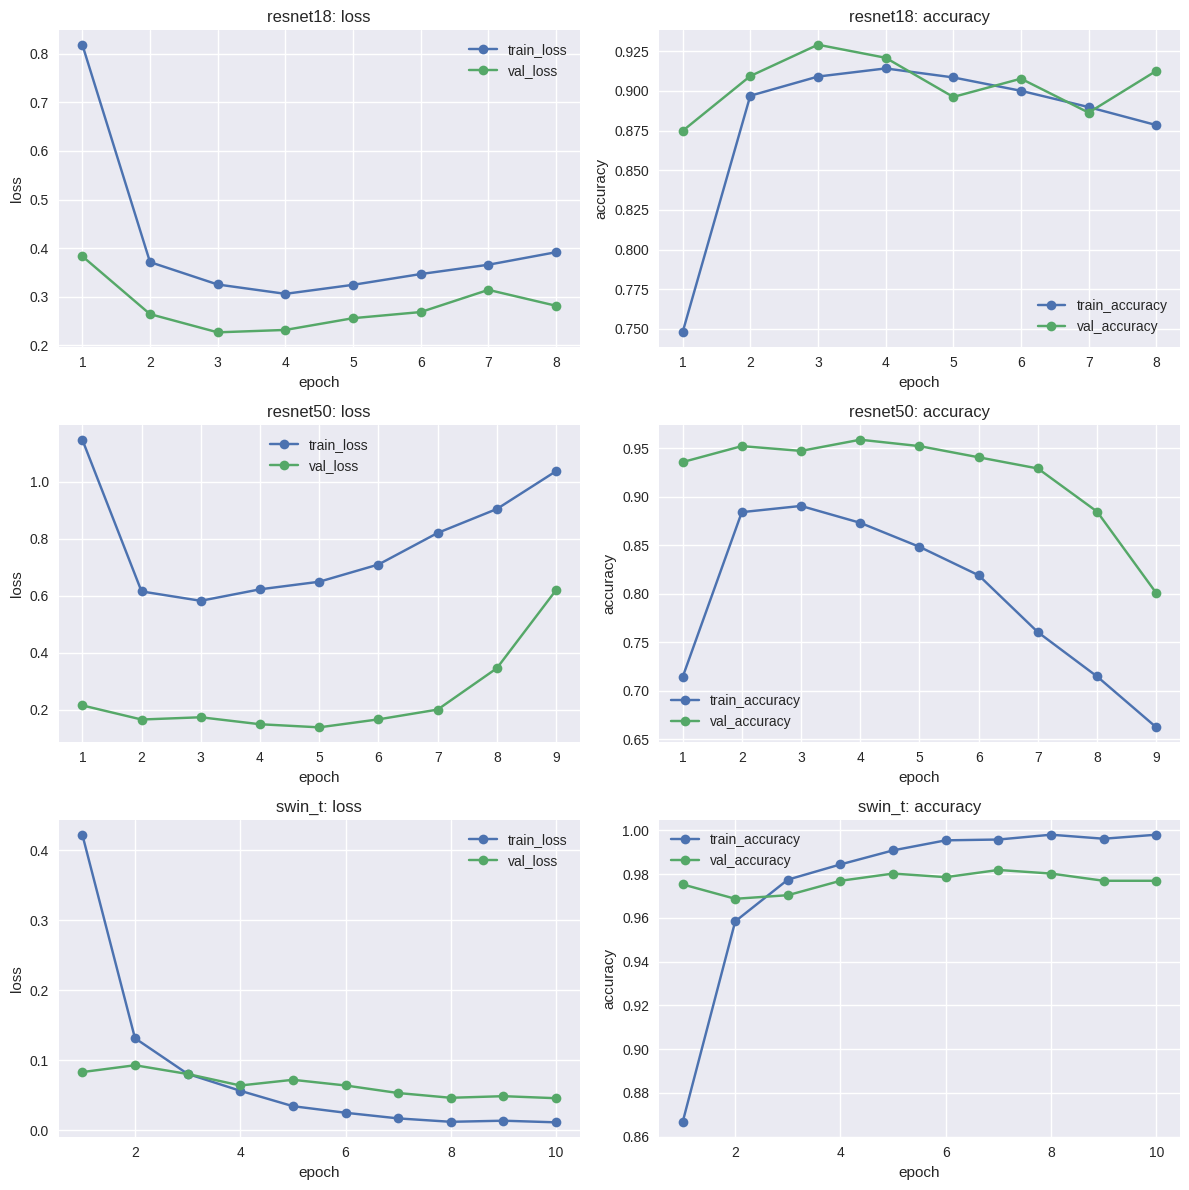

In [16]:
# Optional: Visualise training dynamics per backbone
fig, axes = plt.subplots(len(histories), 2, figsize=(12, 4 * max(1, len(histories))))
if len(histories) == 1:
    axes = np.expand_dims(axes, axis=0)

for row_idx, (backbone, history_df) in enumerate(histories.items()):
    ax_loss, ax_acc = axes[row_idx]
    history_df.plot(x="epoch", y=["train_loss", "val_loss"], ax=ax_loss, marker="o")
    ax_loss.set_title(f"{backbone}: loss")
    ax_loss.set_xlabel("epoch")
    ax_loss.set_ylabel("loss")

    history_df.plot(x="epoch", y=["train_accuracy", "val_accuracy"], ax=ax_acc, marker="o")
    ax_acc.set_title(f"{backbone}: accuracy")
    ax_acc.set_xlabel("epoch")
    ax_acc.set_ylabel("accuracy")

plt.tight_layout()
plt.show()


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]


=== Sketch diagnostics for resnet18 ===


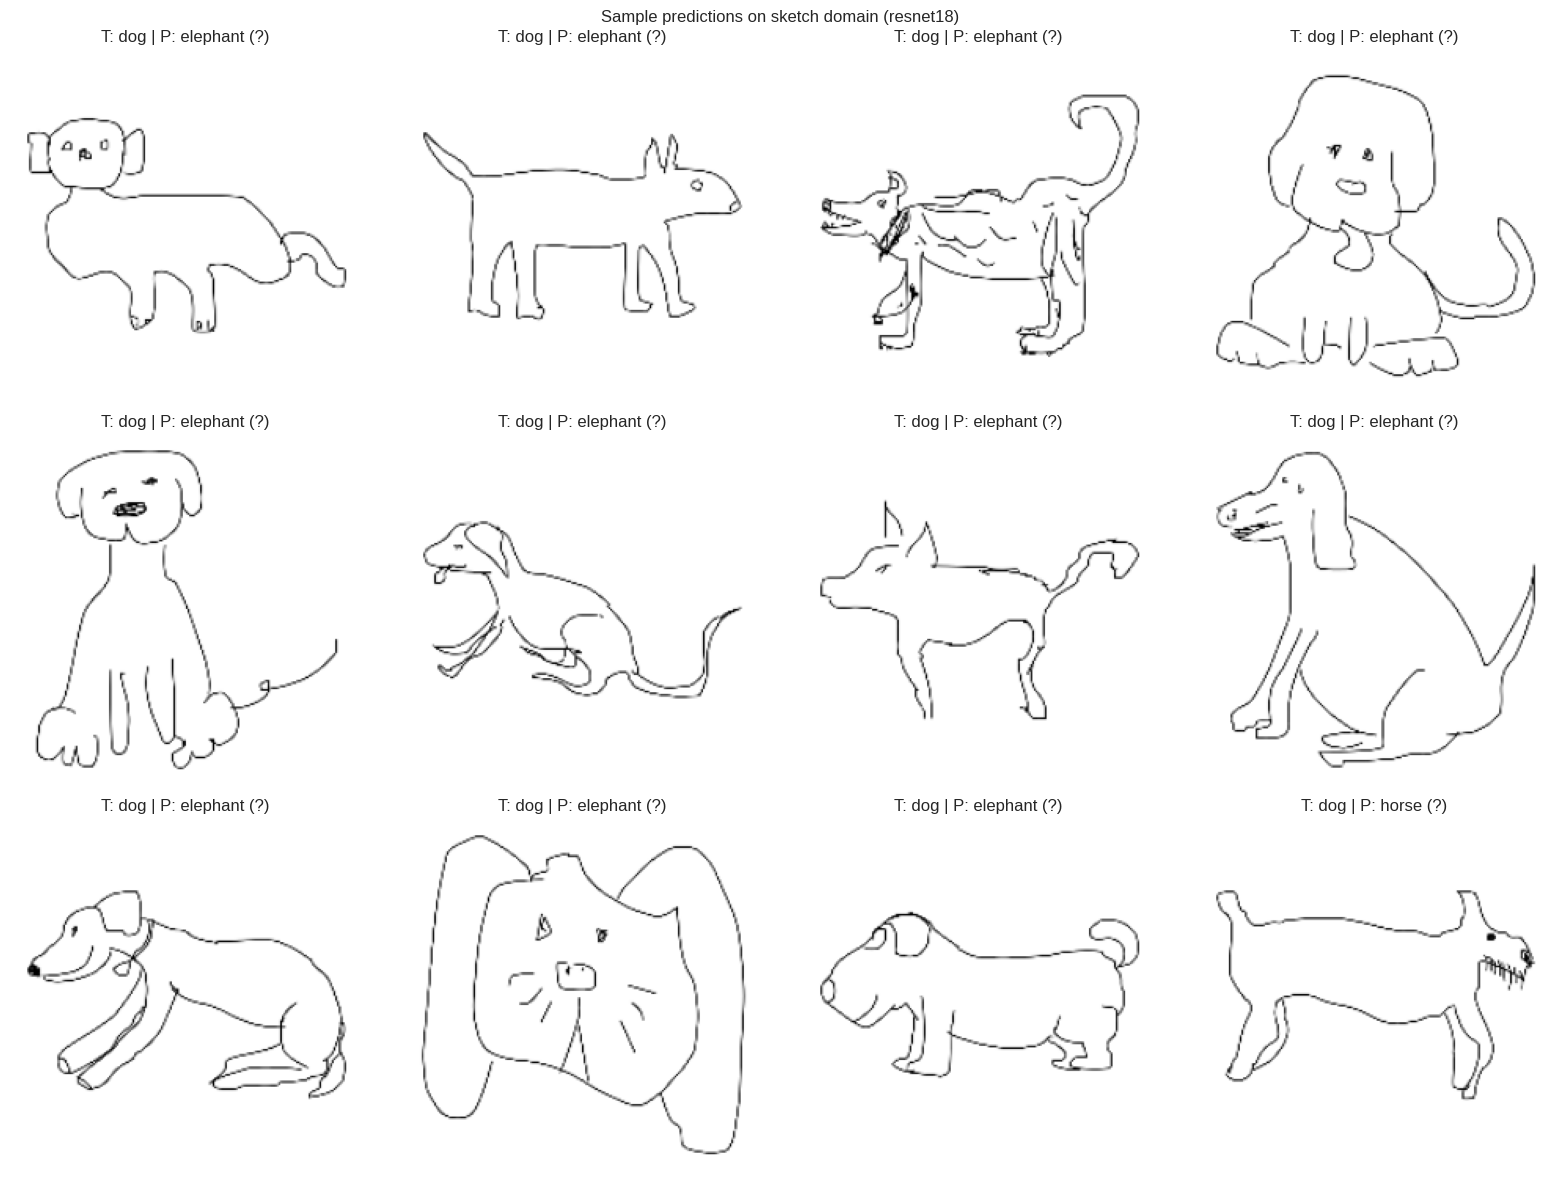

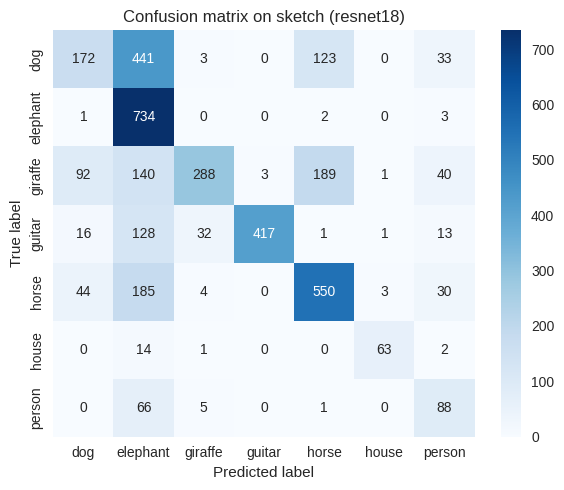

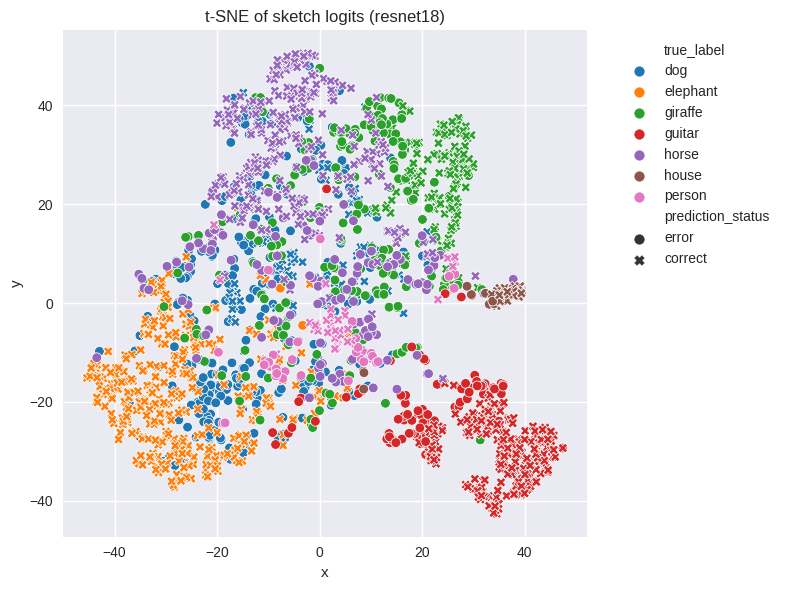

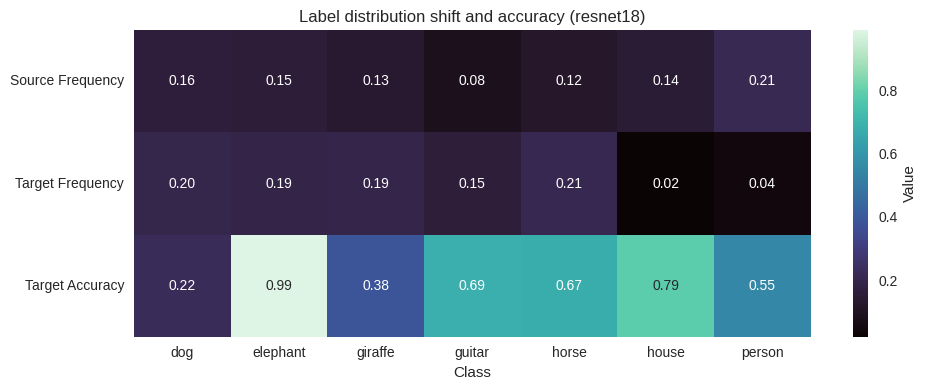


=== Sketch diagnostics for resnet50 ===


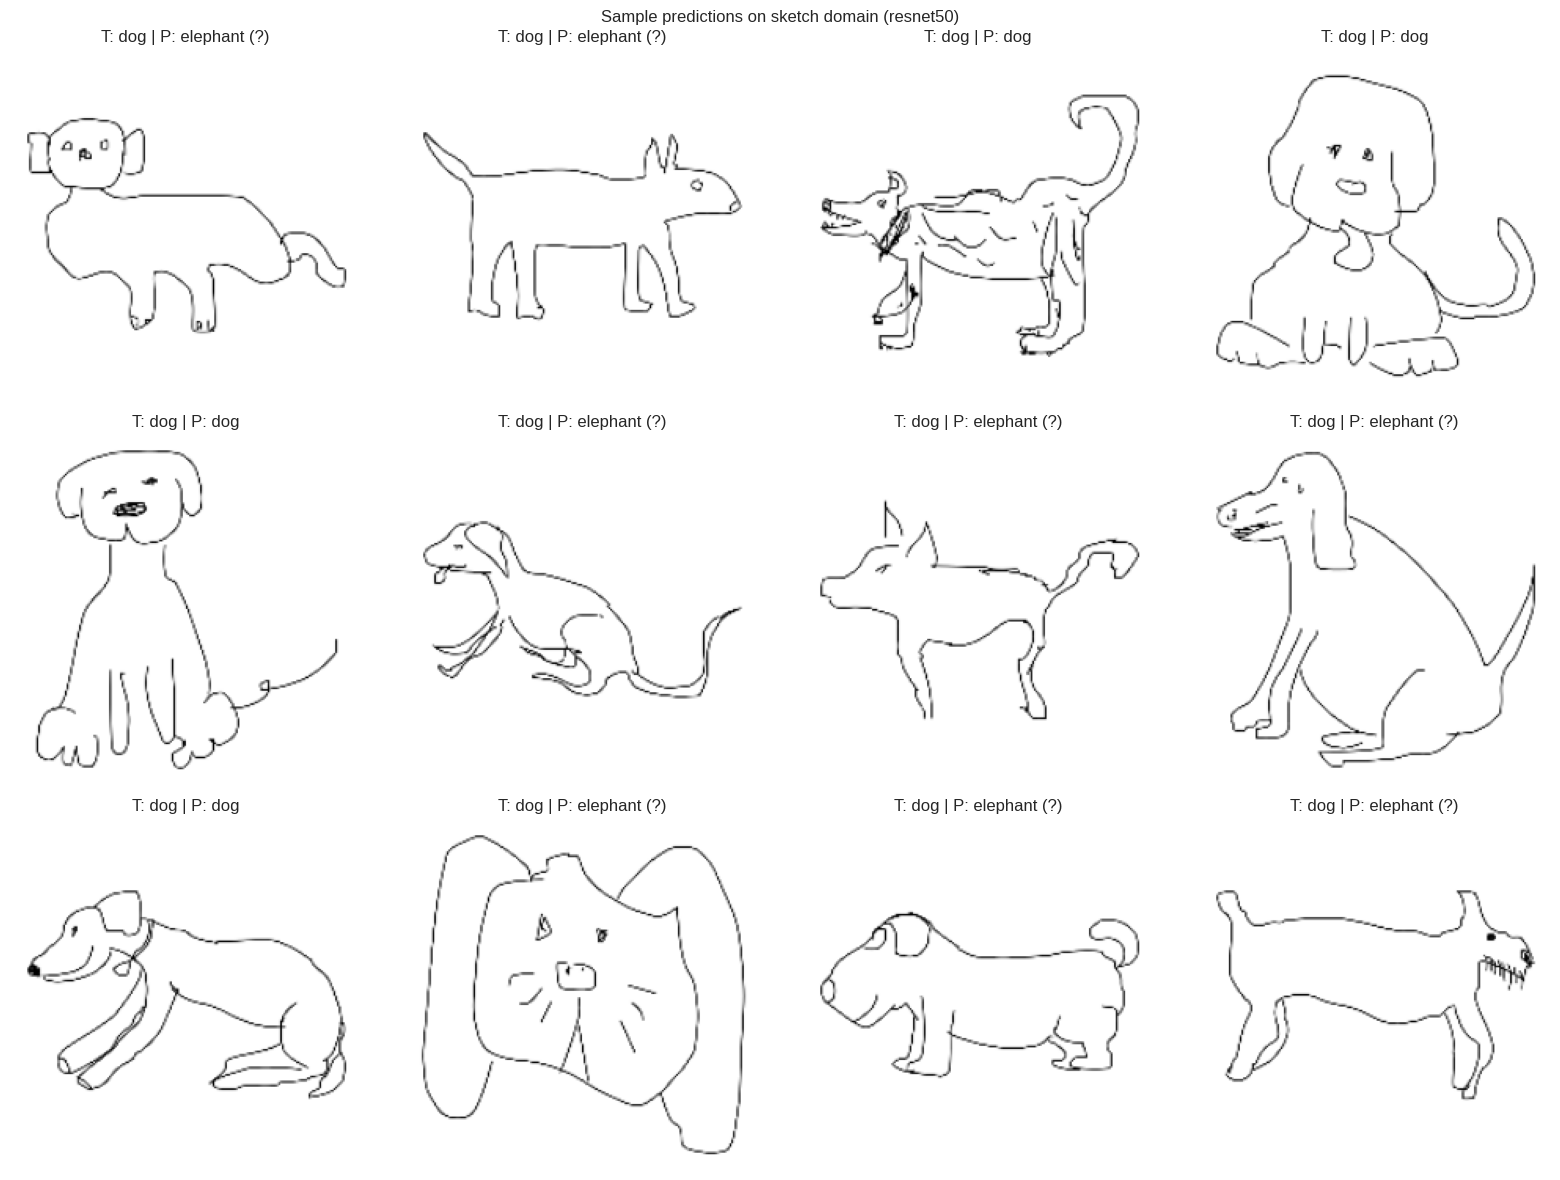

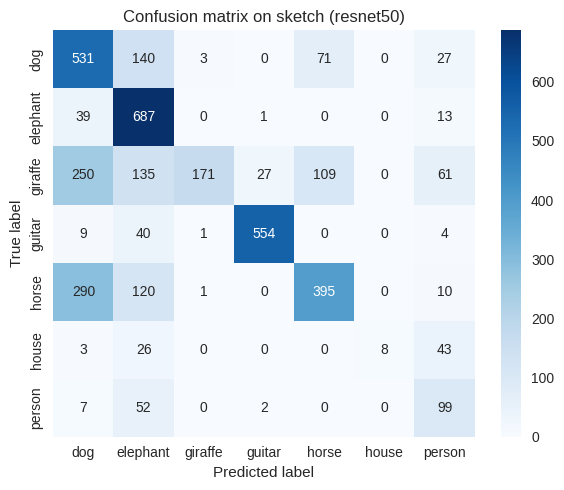

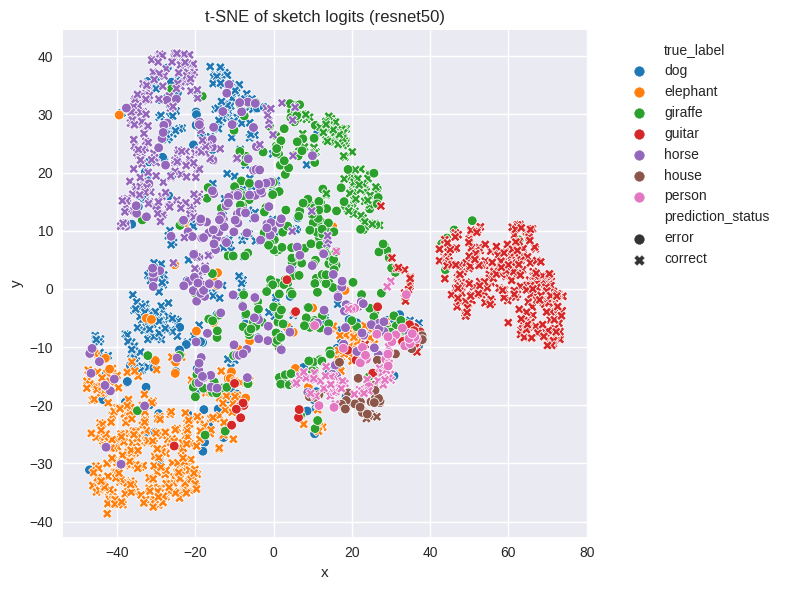

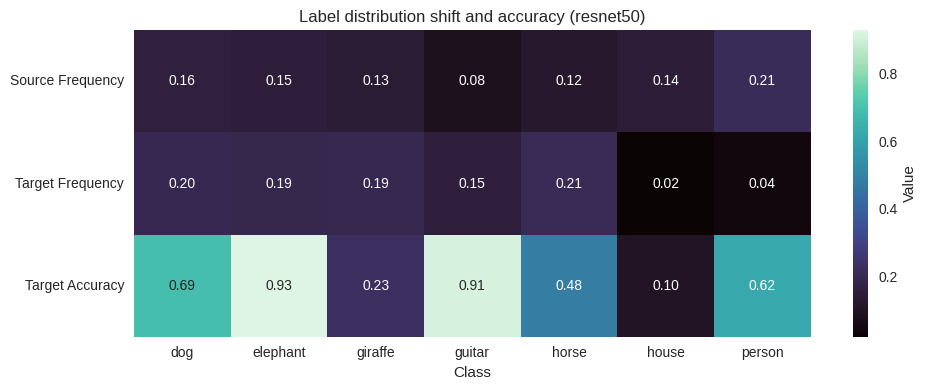


=== Sketch diagnostics for swin_t ===


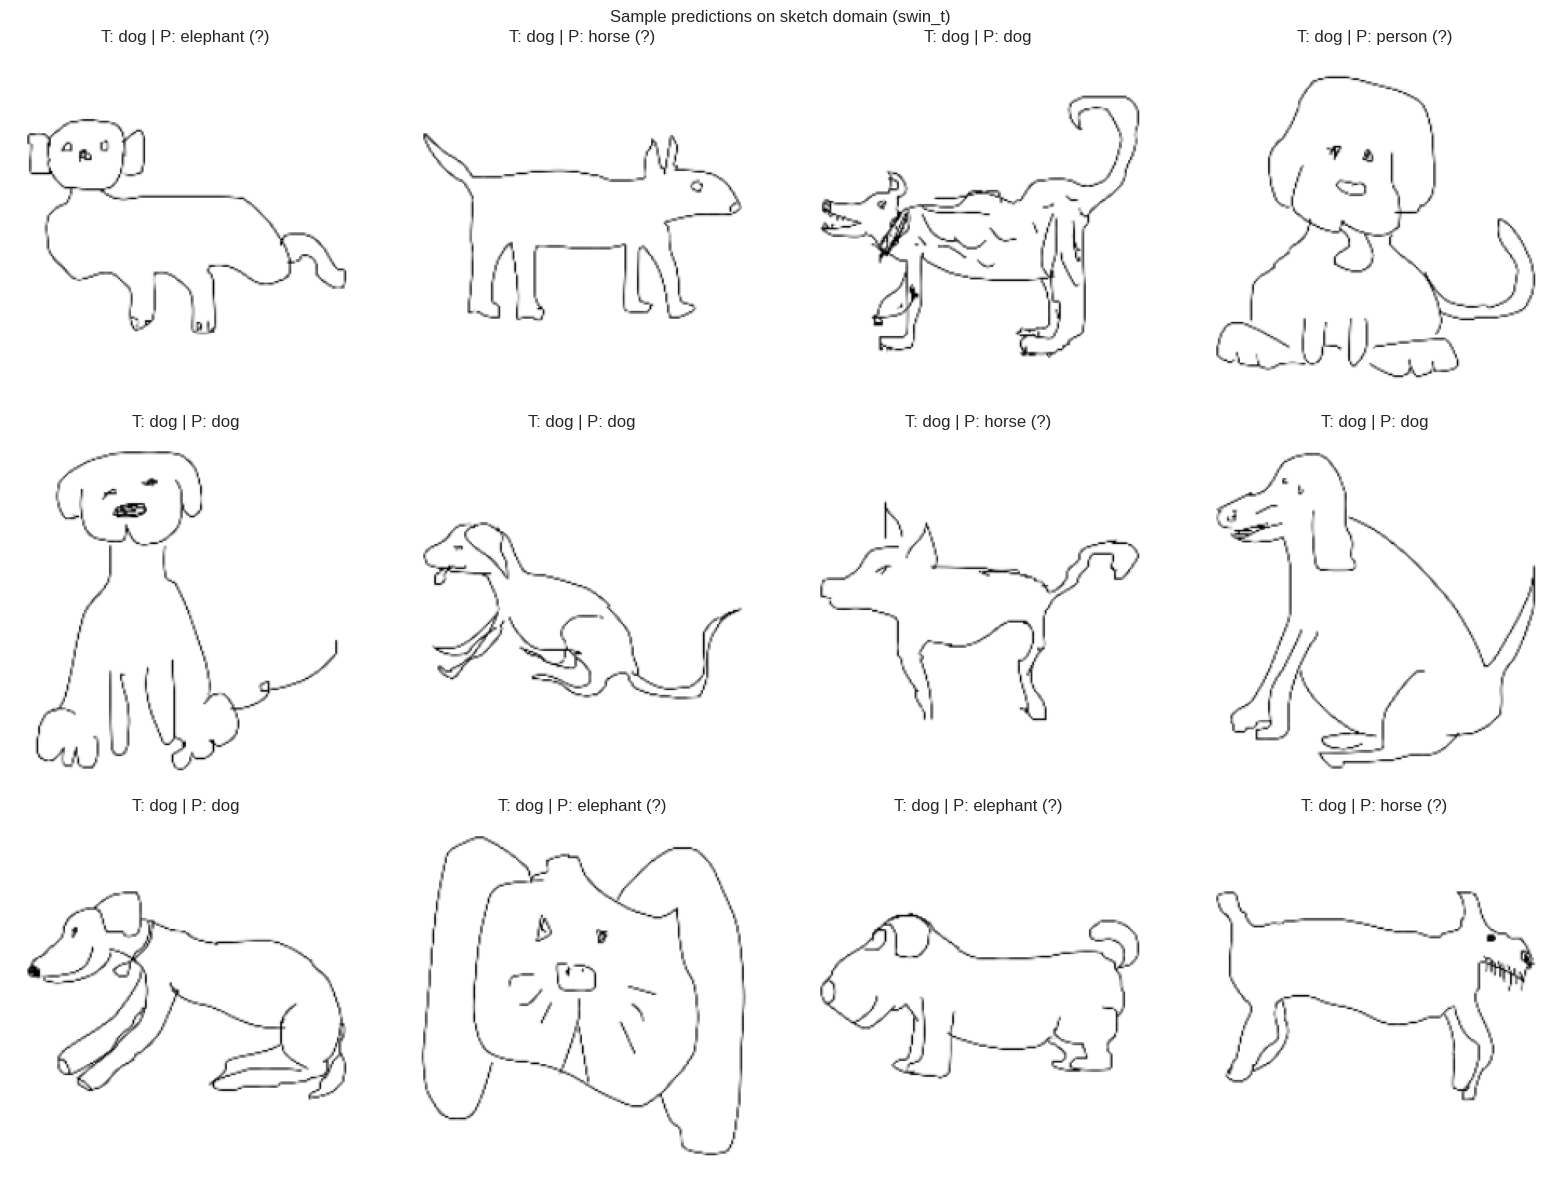

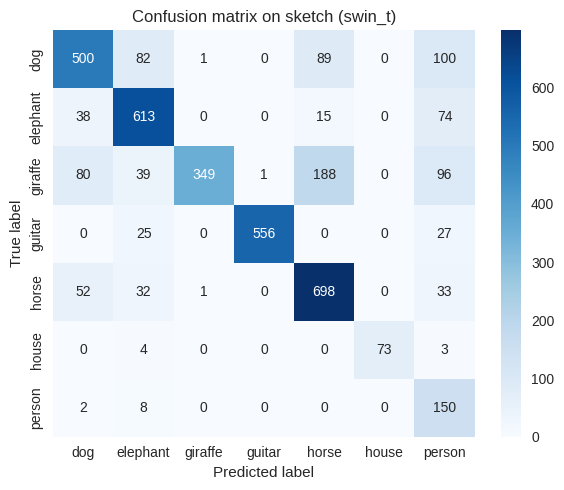

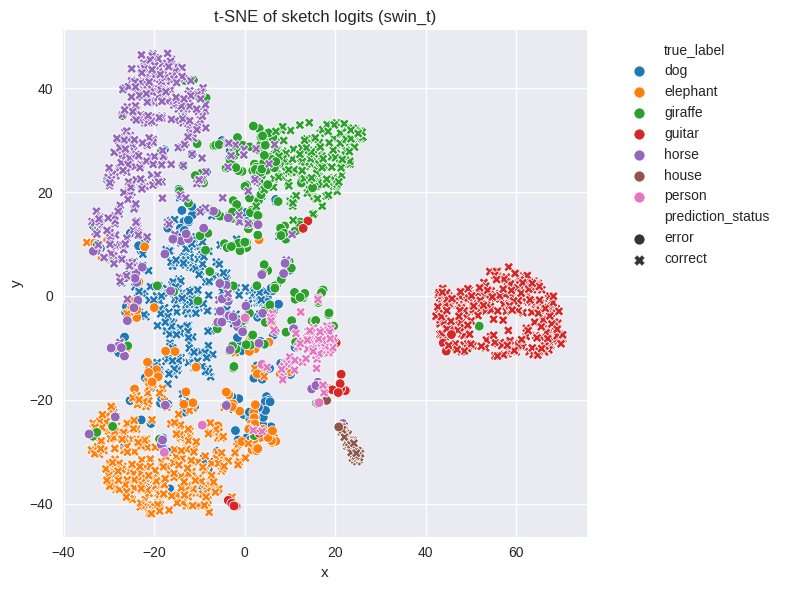

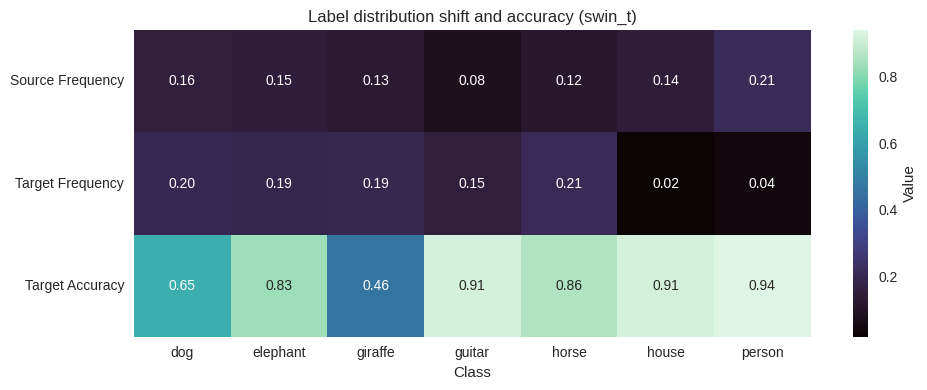

,architecture,sketch_accuracy,evaluated_samples
0,swin_t,0.748027,3929
1,resnet50,0.622296,3929
2,resnet18,0.588445,3929


In [17]:
# Visual diagnostics for the sketch domain (all backbones)
if "experiment_summaries" not in globals() or "loaders" not in globals():
    raise RuntimeError("Run the training pipeline before executing the diagnostics.")

hf_kwargs = {}
if config.hf_cache_dir is not None:
    hf_kwargs["cache_dir"] = str(config.hf_cache_dir)

full_dataset = load_dataset(config.hf_dataset, split=config.hf_split, **hf_kwargs)
label_names = get_label_names_from_dataset(full_dataset, config)
source_freq, target_freq = compute_domain_frequencies(full_dataset, config)
target_loader = loaders["target_loader"]

diagnostic_summaries: List[Dict[str, object]] = []

for summary in experiment_summaries:
    arch = summary["architecture"]
    print(f"\n=== Sketch diagnostics for {arch} ===")
    model = load_model_from_summary(summary, config, device)
    predictions = collect_domain_predictions(model, target_loader, device, config, sample_limit=12)
    logits = predictions["logits"]
    preds = predictions["preds"]
    labels = predictions["labels"]
    samples = predictions["samples"]

    overall_accuracy = float((preds == labels).mean()) if len(labels) else float('nan')

    plot_sample_predictions(samples, label_names, arch)
    plot_confusion_matrix_heatmap(labels, preds, label_names, arch)
    plot_tsne_embedding(logits, labels, preds, label_names, arch, seed=config.seed)
    class_accuracy = compute_class_accuracy(labels, preds, config.num_classes)
    plot_distribution_shift_heatmap(source_freq, target_freq, class_accuracy, label_names, arch)

    diagnostic_summaries.append(
        {
            "architecture": arch,
            "sketch_accuracy": overall_accuracy,
            "evaluated_samples": int(len(labels)),
        }
    )

if diagnostic_summaries:
    diagnostic_df = pd.DataFrame(diagnostic_summaries)
    display(diagnostic_df.sort_values("sketch_accuracy", ascending=False).reset_index(drop=True))
else:
    print("No diagnostics generated; ensure training completed successfully.")
